<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#训练-带有-CT-值的数据" data-toc-modified-id="训练-带有-CT-值的数据-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>训练 带有 CT 值的数据</a></span></li><li><span><a href="#数据预处理" data-toc-modified-id="数据预处理-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>数据预处理</a></span></li></ul></div>

# 训练 带有 CT 值的数据

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame

import random  

import keras
import tensorflow as tf
from keras import backend as K
from keras.layers import LSTM, TimeDistributed, BatchNormalization, Bidirectional, Dense, Dropout
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers.recurrent import GRU
from keras.layers import *
from keras.utils.vis_utils import plot_model

import time

Using TensorFlow backend.


In [94]:
class RNN_train():
    """
    RNN  预测完整的 DOSE 分布
    200组 数据集，预处理后 输入： 200*240 输出： 200*240
    4 种模型选择 ， LSTM ，BiLSTM，GRU， BiGRU 
    """

    def __init__(self):
        self.UNITS = 32  # Units 数目
        self.EPOCHS = 200  # 训练循环数目
        self.TEST_SIZE = 0.2  # 数据集分割比例
        self.VAL = 0.2  # val 分割比例
        self.BATCH_SIZE = 32  # 一次训练多少组
        self.seed = 1340  # 随机数种子
        self.PATIENCE = 30  # 允许不降落步数
        self.OUTPUT_SIZE = 1  # 输入一个 输出 1个
        self.LR = 0.006  # 误差期望
        self.filepath1 = 'train_3.xlsx'  # 文件路径
        self.filepath2 = "Dose_inter_slinear.xlsx"

    def data_pre(self):
        """
        数据预处理 
        """
        df = pd.read_excel(self.filepath1)  # 读取文件
        training_set = DataFrame(df)
        training_set = training_set.T
        
        ct = pd.read_excel(self.filepath2,header= None)
        ct = np.array(ct)
        ct = ct[:,:250]

        X_train_0 = training_set.iloc[:, :302].values
        y_train_0 = training_set.iloc[:, 302:].values
        X_train_0 = X_train_0[:, :250]
        y_train_0 = y_train_0[:, :250]  # 修建 0 值
        
        
        X_train_total = np.zeros((200,250,2))
        for i in range(200):
            X_train_total[i,:,0] = X_train_0[i,:]
        for i in range(200):
            X_train_total[i,:,1] = ct[i%10,:]

        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(
            X_train_total,
            y_train_0,
            test_size=self.TEST_SIZE,
            random_state=self.seed)

        #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
        #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))

        return X_train, y_train, X_test, y_test, X_train_total, y_train_0

    def LSTM_model(self):
        """
        构建 单层双向 GRU 模型 
        """
        model = Sequential()
        model.add(
            GRU(
                input_shape=(250, 2),
                units=self.UNITS,
                return_sequences=True,
                name="GRU"))

        #model.add(Dropout(0.10, name="dropout"))
        model.add(GRU(units=self.UNITS, return_sequences=True, name="GRU_2"))
        model.add(
            TimeDistributed(
                Dense(self.OUTPUT_SIZE, name="Dense"), name="TDense"))
        adam = Adam(self.LR)
        model.compile(
            optimizer=adam,
            loss='mse',
        )
        return model
    
    def BiLSTM_model(self):
        """
        构建 单层双向 GRU 模型 
        """
        model = Sequential()
        model.add(
            Bidirectional(LSTM(
                input_shape=(250, 2),
                units=self.UNITS,
                return_sequences=True,
                name="GRU_1"),name ="BiGRU_1"))

        #model.add(Dropout(0.10, name="dropout_2"))
        
        
        model.add(
            Bidirectional(LSTM(
                input_shape=(250, 2),
                units=self.UNITS,
                return_sequences=True,
                name="GRU_3"),name ="BiGRU_3"))
        model.add(
            TimeDistributed(
                Dense(self.OUTPUT_SIZE, name="Dense"), name="TDense"))
        adam = Adam(self.LR)
        model.compile(
            optimizer=adam,
            loss='mse',
        )
        return model


    def LSTM_model_2(self):
        """
        构建 2层双向 GRU 模型 
        """
        model = Sequential()
        model.add(
            LSTM(
                input_shape=(250, 1),
                units=self.UNITS,
                return_sequences=True,
                name="GRU_1"))

        model.add(Dropout(0.50, name="dropout_1"))
        model.add(LSTM(units=self.UNITS, return_sequences=True, name="GRU_2"))
        model.add(Dropout(0.50, name="dropout_2"))
        model.add(
            TimeDistributed(
                Dense(self.OUTPUT_SIZE, name="Dense"), name="TDense"))
        adam = Adam(self.LR)
        model.compile(
            optimizer=adam,
            loss='mse',
        )
        return model

    def LSTM_model_3(self):
        """
        构建 3 层双向 GRU 模型 
        """
        model = Sequential()
        model.add(
            LSTM(
                input_shape=(250, 1),
                units=self.UNITS,
                return_sequences=True,
                name="GRU_1"))

        model.add(Dropout(0.50, name="dropout_1"))
        model.add(GRU(units=self.UNITS, return_sequences=True, name="GRU_2"))
        model.add(Dropout(0.50, name="dropout_2"))
        model.add(GRU(units=self.UNITS, return_sequences=True, name="GRU_3"))
        model.add(Dropout(0.50, name="dropout_3"))
        model.add(
            TimeDistributed(
                Dense(self.OUTPUT_SIZE, name="Dense"), name="TDense"))
        adam = Adam(self.LR)
        model.compile(
            optimizer=adam,
            loss='mse',
        )
        return model

    def LSTM_model_4(self):
        """
        构建 4 层双向 GRU 模型 
        """
        model = Sequential()
        model.add(
            LSTM(
                input_shape=(250, 1),
                units=self.UNITS,
                return_sequences=True,
                name="GRU_1"))

        model.add(Dropout(0.50, name="dropout_1"))
        model.add(LSTM(units=self.UNITS, return_sequences=True, name="GRU_2"))
        model.add(Dropout(0.50, name="dropout_2"))
        model.add(LSTM(units=self.UNITS, return_sequences=True, name="GRU_3"))
        model.add(Dropout(0.50, name="dropout_3"))
        model.add(LSTM(units=self.UNITS, return_sequences=True, name="GRU_4"))
        model.add(Dropout(0.50, name="dropout_4"))
        model.add(
            TimeDistributed(
                Dense(self.OUTPUT_SIZE, name="Dense"), name="TDense"))
        adam = Adam(self.LR)
        model.compile(
            optimizer=adam,
            loss='mse',
        )
        return model

    def LSTM_model_5(self):
        """
        构建 5 层双向 GRU 模型 
        """
        model = Sequential()
        model.add(
            LSTM(
                input_shape=(250, 1),
                units=self.UNITS,
                return_sequences=True,
                name="GRU_1"))

        model.add(Dropout(0.50, name="dropout_1"))
        model.add(LSTM(units=self.UNITS, return_sequences=True, name="GRU_2"))
        model.add(Dropout(0.50, name="dropout_2"))
        model.add(LSTM(units=self.UNITS, return_sequences=True, name="GRU_3"))
        model.add(Dropout(0.50, name="dropout_3"))
        model.add(LSTM(units=self.UNITS, return_sequences=True, name="GRU_4"))
        model.add(Dropout(0.50, name="dropout_4"))
        model.add(LSTM(units=self.UNITS, return_sequences=True, name="GRU_5"))
        model.add(Dropout(0.50, name="dropout_5"))
        model.add(
            TimeDistributed(
                Dense(self.OUTPUT_SIZE, name="Dense"), name="TDense"))
        adam = Adam(self.LR)
        model.compile(
            optimizer=adam,
            loss='mse',
        )
        return model

    def model_train(self, model):
        """
        训练模型， 输入 compile 之后的模型 ，返回训练的模型
        """
        X_train, y_train, X_test, y_test, _, _ = self.data_pre()
        early_stopping = EarlyStopping(
            monitor='val_loss', patience=self.PATIENCE, verbose=0, mode='min')
        history = model.fit(
            X_train,
            y_train,
            batch_size=self.BATCH_SIZE,
            epochs=self.EPOCHS,
            verbose=1,
            validation_split=self.VAL,  # 加入 交叉验证集
            callbacks=[early_stopping])

        return history, model

    def train_plot(self, history):
        """
        绘制 训练的 loss 和 val_loss 图
        """
        plt.figure(figsize=(20, 10))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.ylabel("loss", fontsize=30)
        plt.xlabel("epoch", fontsize=30)
        plt.legend(["train_loss", "val_loss"], loc="upper right")
        plt.show()

    def loss_cal(self, model):
        """
        计算 评估模型的指标  
        输入训练好的模型
        """
        X_train, y_train, X_test, y_test, _, _ = self.data_pre()
        N = X_test.shape[0]  # 测试数据的数目

        test_loss_total = []
        peak_loss_total = []
        peak_shift_total = []
        peak_half_loss_list = []
        peak_twenty_percent_loss_list = []

        for i in range(N):

            X_test[i] = np.array(X_test[i], dtype=float)
            y_test[i] = np.array(y_test[i], dtype=float)
            X_test_0 = X_test[i][np.newaxis, :, :]
            y_test_0 = y_test[i][np.newaxis, :, :]

            # 计算 测试集总误差

            y_test_0_pred = model.predict(X_test_0)
            test_loss = np.mean(np.square(y_test_0_pred - y_test_0))
            test_loss_total.append(test_loss)

            x_pre = model.predict(X_test_0)
            x_pre = x_pre.ravel()  # 调整形状
            x_pre = np.array(x_pre, dtype=np.float64)  # 调整 数据
            x_real = y_test_0.ravel()

            # 计算测试集 peak 偏移
            peak_shift = abs(np.argmax(x_real) - np.argmax(x_pre))
            peak_shift_total.append(peak_shift)

            # 转换为列表
            x_real_list = x_real.tolist()
            x_pre_list = x_pre.tolist()

            # 计算 测试集 距离峰值一半的偏差
            half_peak = x_real.max() * 0.5
            for j in x_real[:np.argmax(x_real)]:
                if j > half_peak or j == half_peak:
                    index_l1 = x_real_list.index(j)
                    break
            for j in x_real[np.argmax(x_real):]:
                if j < half_peak or j == half_peak:
                    index_r1 = x_real_list[np.argmax(x_real):].index(
                        j) + np.argmax(x_real)
                    break

            half_loss = [
                abs(x_real_list[i] - x_pre_list[i])
                for i in range(index_l1, index_r1)
            ]
            peak_half_loss = np.mean(np.square(half_loss))
            peak_half_loss_list.append(peak_half_loss)

            # 计算距离峰值 20% 的偏差
            twenty_percent_peak = x_real.max() * 0.2
            for i in x_real[:np.argmax(x_real)]:
                if i > twenty_percent_peak or i == twenty_percent_peak:
                    index_l2 = x_real_list.index(i)
                    break

            for i in x_real[np.argmax(x_real):]:
                if i < twenty_percent_peak or i == twenty_percent_peak:
                    index_r2 = x_real_list[np.argmax(x_real):].index(
                        i) + np.argmax(x_real)
                    break
            twenty_percent_loss = [
                abs(x_real_list[i] - x_pre_list[i])
                for i in range(index_l2, index_r2)
            ]
            peak_twenty_percent_loss = np.mean(np.square(twenty_percent_loss))
            peak_twenty_percent_loss_list.append(peak_twenty_percent_loss)

            i = i + 1

        peak_shift_MAE = np.mean(peak_shift_total)
        peak_shift_MSE = np.mean(np.square(peak_shift_total))
        peak_twenty_percent_loss_ave = np.mean(peak_twenty_percent_loss_list)
        peak_half_loss_ave = np.mean(peak_half_loss_list)
        test_loss_total_ave = np.mean(test_loss_total)

        return peak_shift_MAE, peak_shift_MSE, test_loss_total_ave,peak_half_loss_ave, peak_twenty_percent_loss_ave

    def curve_shift(self, model):

        X_train, y_train, X_test, y_test, _, _ = self.data_pre()

        per_average_total = []
        per50_average_total = []
        per20_average_total = []
        N = X_test.shape[0]

        for i in range(N):
            X_test[i] = np.array(X_test[i], dtype=float)
            y_test[i] = np.array(y_test[i], dtype=float)
            X_test_0 = X_test[i][np.newaxis, :, :]
            y_test_0 = y_test[i][np.newaxis, :, :]

            x_pre = model.predict(X_test_0, batch_size=1, verbose=0)
            x_pre = x_pre.ravel()  # 调整形状
            x_pre = np.array(x_pre, dtype=np.float64)  # 调整 数据
            x_real = y_test_0.ravel()

            # 计算曲线的 总偏移
            #curve_shift = x_real - x_pre
            per_list = []
            n = 0
            for i in range(240):
                if x_real[i] > 1e-3:
                    n = n + 1
                    a = abs(x_real[i] - x_pre[i]) / x_real[i]
                    per_list.append(a)
            per_average = sum(per_list) / n
            per_average_total.append(per_average)

            # 计算曲线的半高偏移

            # 转换为列表
            x_real_list = x_real.tolist()
            x_pre_list = x_pre.tolist()

            # 计算 测试集 距离峰值一半的偏差
            half_peak = x_real.max() * 0.5
            for j in x_real[:np.argmax(x_real)]:
                if j > half_peak or j == half_peak:
                    index_l1 = x_real_list.index(j)
                    break
            for j in x_real[np.argmax(x_real):]:
                if j < half_peak or j == half_peak:
                    index_r1 = x_real_list[np.argmax(x_real):].index(
                        j) + np.argmax(x_real)
                    break

            per50_list = [
                abs(x_real_list[i] - x_pre_list[i]) / x_real_list[i]
                for i in range(index_l1, index_r1)
            ]

            per50_average = sum(per50_list) / (index_r1 - index_l1)
            per50_average_total.append(per50_average)

            # 计算距离峰值 20% 的偏差
            twenty_percent_peak = x_real.max() * 0.2
            for i in x_real[:np.argmax(x_real)]:
                if i > twenty_percent_peak or i == twenty_percent_peak:
                    index_l2 = x_real_list.index(i)
                    break

            for i in x_real[np.argmax(x_real):]:
                if i < twenty_percent_peak or i == twenty_percent_peak:
                    index_r2 = x_real_list[np.argmax(x_real):].index(
                        i) + np.argmax(x_real)
                    break
            per20_list = [
                abs(x_real_list[i] - x_pre_list[i]) / x_real_list[i]
                for i in range(index_l2, index_r2)
            ]

            per20_average = sum(per20_list) / (index_r2 - index_l2)
            per20_average_total.append(per20_average)

            i = i + 1

        per100 = sum(per_average_total) / N
        per50 = sum(per50_average_total) / N
        per20 = sum(per20_average_total) / N

        return per100, per50, per20

Train on 128 samples, validate on 32 samples
Epoch 1/200
128/128 [==============================] - 7s 54ms/step - loss: 0.2576 - val_loss: 0.1474
Epoch 2/200
128/128 [==============================] - 1s 12ms/step - loss: 0.1212 - val_loss: 0.0460
Epoch 3/200
128/128 [==============================] - 2s 12ms/step - loss: 0.0569 - val_loss: 0.0679
Epoch 4/200
128/128 [==============================] - 2s 12ms/step - loss: 0.0516 - val_loss: 0.0396
Epoch 5/200
128/128 [==============================] - 1s 11ms/step - loss: 0.0453 - val_loss: 0.0447
Epoch 6/200
128/128 [==============================] - 1s 11ms/step - loss: 0.0426 - val_loss: 0.0388
Epoch 7/200
128/128 [==============================] - 1s 11ms/step - loss: 0.0397 - val_loss: 0.0437
Epoch 8/200
128/128 [==============================] - 1s 11ms/step - loss: 0.0400 - val_loss: 0.0375
Epoch 9/200
128/128 [==============================] - 2s 12ms/step - loss: 0.0369 - val_loss: 0.0360
Epoch 10/200
128/128 [===============

128/128 [==============================] - 1s 12ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 81/200
128/128 [==============================] - 2s 13ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 82/200
128/128 [==============================] - 2s 14ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 83/200
128/128 [==============================] - 2s 12ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 84/200
128/128 [==============================] - 2s 13ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 85/200
128/128 [==============================] - 2s 15ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 86/200
128/128 [==============================] - 2s 12ms/step - loss: 0.0067 - val_loss: 0.0090
Epoch 87/200
128/128 [==============================] - 1s 11ms/step - loss: 0.0064 - val_loss: 0.0046
Epoch 88/200
128/128 [==============================] - 1s 11ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 89/200
128/128 [==============================] - 1s 11ms/step - loss: 0.0034 - 

128/128 [==============================] - 2s 13ms/step - loss: 3.3985e-04 - val_loss: 6.7839e-04
Epoch 157/200
128/128 [==============================] - 2s 13ms/step - loss: 4.7333e-04 - val_loss: 6.5528e-04
Epoch 158/200
128/128 [==============================] - 1s 11ms/step - loss: 6.3387e-04 - val_loss: 4.9928e-04
Epoch 159/200
128/128 [==============================] - 1s 12ms/step - loss: 5.0733e-04 - val_loss: 4.9366e-04
Epoch 160/200
128/128 [==============================] - 2s 12ms/step - loss: 4.3255e-04 - val_loss: 4.2091e-04
Epoch 161/200
128/128 [==============================] - 1s 12ms/step - loss: 3.2952e-04 - val_loss: 4.4808e-04
Epoch 162/200
128/128 [==============================] - 1s 11ms/step - loss: 2.9734e-04 - val_loss: 3.9899e-04
Epoch 163/200
128/128 [==============================] - 1s 12ms/step - loss: 2.9247e-04 - val_loss: 3.9379e-04
Epoch 164/200
128/128 [==============================] - 1s 11ms/step - loss: 3.2120e-04 - val_loss: 4.4644e-04
Epoch 

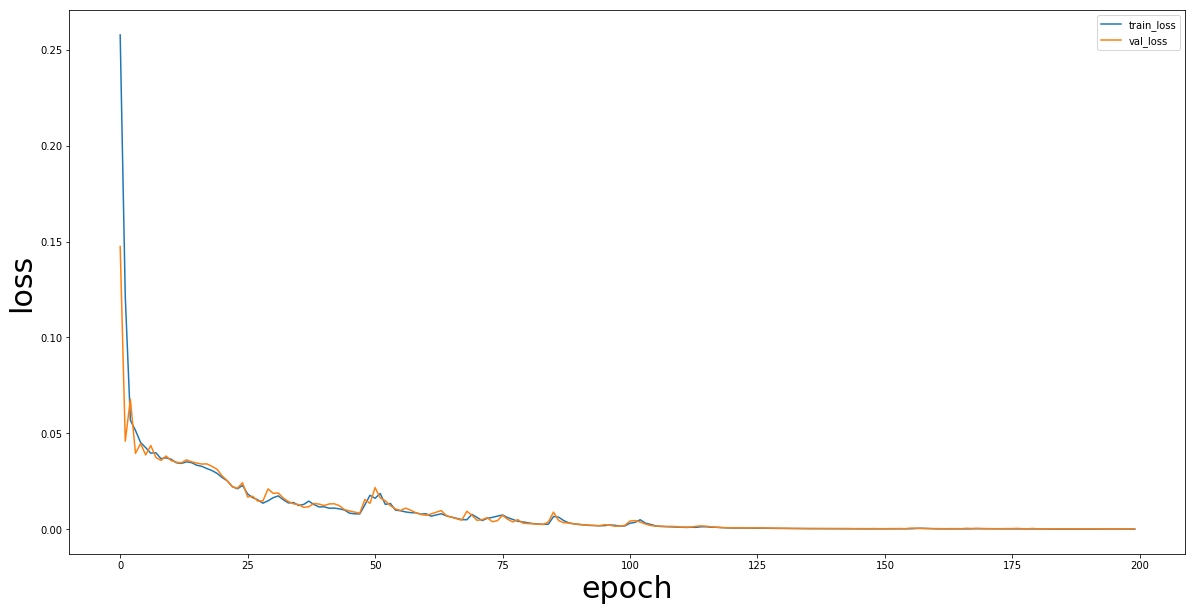

In [95]:
if __name__ == '__main__':
    RNN = RNN_train()
    model = RNN.BiLSTM_model()
    history, model = RNN.model_train(model)
    RNN.train_plot(history)

In [96]:
RNN.loss_cal(model)

(0.45,
 0.5,
 0.0002798076996769938,
 0.0020121534514598916,
 0.0004690314929167428)

In [98]:
RNN.curve_shift(model)

(0.20260387170097136, 0.048113212524699696, 0.03483214846532989)

In [97]:
model.save("ct_BiLSTM_2.h5")

# 数据预处理

In [12]:
x0= np.arange(511)  # 原始数据
x_new = np.linspace(x0.min(), x0.max(), 302)  # 插值成 512 个点

In [14]:
# 限制插值点的范围
from scipy import interpolate 
dose_list_slinear = []
for i in range(10):
    dose = ct[i]
    f = interpolate.interp1d(x0, dose, kind="slinear")
    dose_new = f(x_new)
    dose_list_slinear.append(dose_new)

Dose_inter_slinear = np.array(dose_list_slinear)
print("Dose_inter_slinear 是不是 ndarray 类型 ？ ", isinstance(Dose_inter_slinear,
                                                 np.ndarray))
print("Dose_inter_slinear  Size : ", np.shape(Dose_inter_slinear))

Dose_inter_slinear 是不是 ndarray 类型 ？  True
Dose_inter_slinear  Size :  (10, 302)


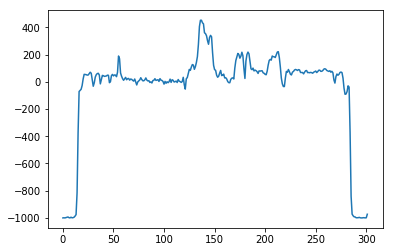

In [15]:
plt.plot(Dose_inter_slinear[1,:])

In [17]:
data_df = pd.DataFrame(Dose_inter_slinear)

writer = pd.ExcelWriter('Dose_inter_slinear.xlsx')
data_df.to_excel(writer, 'page_1', float_format='%.8f',header=None,index=None,columns=None)  # float_format 控制精度
writer.save()

In [22]:
ct = pd.read_excel("Dose_inter_slinear.xlsx",header= None)
ct = np.array(ct)

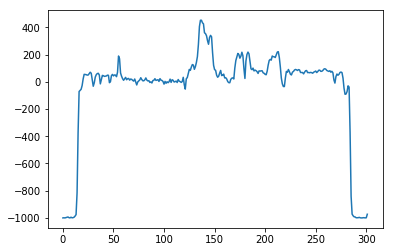

In [23]:
plt.plot(ct[1,:])

In [24]:
df = pd.read_excel("train_3.xlsx")  # 读取文件
training_set = DataFrame(df)
training_set = training_set.T
X_train_0 = training_set.iloc[:, :302].values
y_train_0 = training_set.iloc[:, 302:].values
X_train_0 = X_train_0[:, :250]
y_train_0 = y_train_0[:, :250]  # 修建 0 值

In [25]:
ct = ct[:,:250]
X_train_total = np.zeros((200,250,2))
for i in range(200):
    X_train_total[i,:,0] = X_train_0[i,:]
for i in range(200):
    X_train_total[i,:,1] = ct[i%10,:]

In [26]:
X_train_total = np.zeros((200,250,2))

In [29]:
import math

In [35]:
for i in range(200):
    X_train_total[i,:,0] = X_train_0[i,:]
for i in range(200):
    X_train_total[i,:,1] = ct[i%10,:]

In [34]:
21%10

1

In [36]:
X_train_total

array([[[ 0.00000000e+00, -1.00000000e+03],
        [ 0.00000000e+00, -1.00000000e+03],
        [ 0.00000000e+00, -1.00000000e+03],
        ...,
        [ 0.00000000e+00,  7.79102990e+01],
        [ 7.88171000e-04,  6.59966777e+01],
        [ 4.33666000e-04,  8.25116279e+01]],

       [[ 0.00000000e+00, -1.00000000e+03],
        [ 4.12062000e-05, -9.99000000e+02],
        [ 4.12062000e-05, -1.00000000e+03],
        ...,
        [ 4.10272000e-04,  6.25647841e+01],
        [ 0.00000000e+00,  7.02059801e+01],
        [ 8.61751000e-04,  7.37242525e+01]],

       [[ 7.92501000e-05, -1.00000000e+03],
        [ 0.00000000e+00, -9.98305648e+02],
        [ 3.96251000e-05, -9.99388704e+02],
        ...,
        [ 0.00000000e+00,  6.19900332e+01],
        [ 1.22000000e-03,  5.74019934e+01],
        [ 4.34155000e-04,  5.58936877e+01]],

       ...,

       [[ 1.61481940e-04, -1.00000000e+03],
        [ 0.00000000e+00, -1.00000000e+03],
        [ 6.57462200e-04, -1.00000000e+03],
        ...,
     

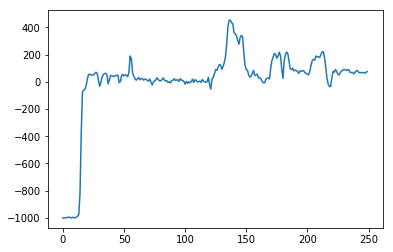

In [37]:
plt.plot(X_train_total[1,:,1])

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
            X_train_total,
            y_train_0,
            test_size=0.2,
            random_state=1340)


In [41]:
np.shape(X_test[1])

(250, 2)